In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [2]:
# Load data
data = pd.read_csv('../01_Data/data_california_house_prepared.csv')

In [3]:
# Pisahkan fitur dan target
X = data.drop('median_house_value', axis=1)
y = data['median_house_value']

RANDOM_STATE = 42

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE)

# Definisikan fitur numerik & kategorikal
numeric_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                    'total_bedrooms', 'population', 'households', 'median_income']
categorical_features = ['ocean_proximity']

# Preprocessor: Imputasi + Scaling + Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

d:\PurwadhikaBackup\capstoneproject\modultiga\california_housing_price_prediction\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.595e+12, tolerance: 1.537e+10
  model = cd_fast.enet_coordinate_descent(


📊 Evaluasi Model:
                Model           MAE           MSE          RMSE      MAPE  \
5            XGBoost  32728.489044  2.429630e+09  49291.279471  0.185406   
4      Random Forest  32608.319675  2.503304e+09  50033.025285  0.187897   
1   Ridge Regression  49834.901645  4.847546e+09  69624.323587  0.290186   
2   Lasso Regression  49837.760417  4.848108e+09  69628.355088  0.290233   
0  Linear Regression  49837.784545  4.848118e+09  69628.427801  0.290233   
3      Decision Tree  45116.620761  5.172154e+09  71917.687355  0.246391   

         R²  
5  0.818019  
4  0.812501  
1  0.636916  
2  0.636874  
0  0.636873  
3  0.612603  

✅ Model terbaik berdasarkan RMSE: **XGBoost**


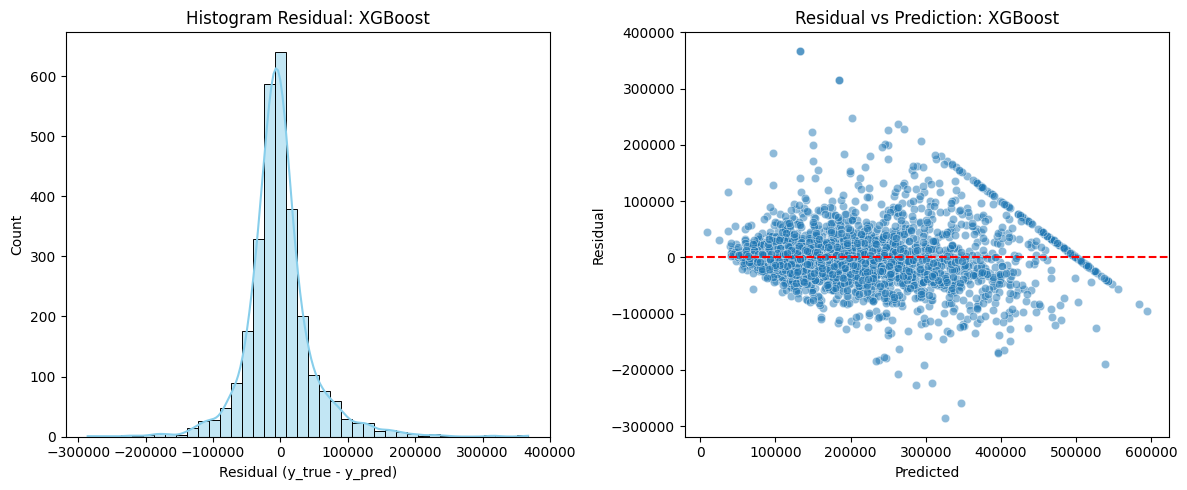

In [4]:
# Daftar model
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Decision Tree": DecisionTreeRegressor(random_state=RANDOM_STATE),
    "Random Forest": RandomForestRegressor(random_state=RANDOM_STATE),
    "XGBoost": XGBRegressor(random_state=RANDOM_STATE, verbosity=0)
}

# Evaluasi model


def evaluate(y_true, y_pred):
    residuals = y_true - y_pred
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, mape, r2, residuals


# Simpan hasil evaluasi
results = []
residuals_dict = {}
fitted_models = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('regressor', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mae, mse, rmse, mape, r2, residuals = evaluate(y_test, y_pred)
    results.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2
    })
    residuals_dict[name] = (y_pred, residuals)
    fitted_models[name] = pipeline

# Tampilkan tabel evaluasi
results_df = pd.DataFrame(results).sort_values(by='RMSE')
print("📊 Evaluasi Model:\n", results_df)

# 💡 Saran model terbaik (berdasarkan RMSE)
best_model = results_df.iloc[0]['Model']
print(f"\n✅ Model terbaik berdasarkan RMSE: **{best_model}**")

# -----------------------------------
# 🔍 Residual Analysis (Visualisasi)
# -----------------------------------
y_pred_best, residuals_best = residuals_dict[best_model]

plt.figure(figsize=(12, 5))

# Histogram residual
plt.subplot(1, 2, 1)
sns.histplot(residuals_best, bins=40, kde=True, color='skyblue')
plt.title(f"Histogram Residual: {best_model}")
plt.xlabel("Residual (y_true - y_pred)")

# Scatter y_pred vs residual
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_best, y=residuals_best, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title(f"Residual vs Prediction: {best_model}")
plt.xlabel("Predicted")
plt.ylabel("Residual")

plt.tight_layout()
plt.show()

In [5]:
# ------------------------------
# 🔍 Feature importance (jika applicable)
# ------------------------------
best_model_name = results_df.iloc[0]['Model']
best_pipeline = fitted_models[best_model_name]
best_model = best_pipeline.named_steps['regressor']  # Ambil model dari pipeline

# Dapatkan nama fitur akhir setelah preprocessing
# Harus fit dulu preprocessor supaya tahu nama fitur encode
preprocessor_fitted = best_pipeline.named_steps['preprocessing']
ohe = preprocessor_fitted.named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)

feature_names = numeric_features + list(encoded_cat_names)

print(f"\n📊 Feature Importance untuk model: {best_model_name}")
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    for idx in sorted_idx:
        print(f"{feature_names[idx]}: {importances[idx]:.4f}")
elif hasattr(best_model, "coef_"):
    coef = best_model.coef_
    if coef.ndim > 1:
        coef = coef[0]  # Handle shape (1, n)
    sorted_idx = np.argsort(np.abs(coef))[::-1]
    for idx in sorted_idx:
        print(f"{feature_names[idx]}: {coef[idx]:.4f}")
else:
    print("⚠️ Model ini tidak mendukung feature importance secara langsung.")



📊 Feature Importance untuk model: XGBoost
ocean_proximity_INLAND: 0.5800
median_income: 0.1814
ocean_proximity_NEAR OCEAN: 0.0585
ocean_proximity_NEAR BAY: 0.0317
latitude: 0.0291
longitude: 0.0248
housing_median_age: 0.0233
total_bedrooms: 0.0182
population: 0.0181
ocean_proximity_<1H OCEAN: 0.0168
households: 0.0098
total_rooms: 0.0083


In [6]:
# Ambil nama model terbaik
best_model_name = results_df.iloc[0]['Model']
# Ambil pipeline dari model terbaik
best_model_pipeline = fitted_models[best_model_name]

# Simpan ke file
joblib.dump(best_model_pipeline, '../03_Model/03_best_model.pkl')
print('✅ Model berhasil disimpan')

✅ Model berhasil disimpan
